<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification Model Analysis <br>
**Notebook 4: Sentiment Analysis, Conclusion & Recommendation**

## TABLE OF CONTENTS

**1. Web Scrapping** <br>
**2. Data Cleaning & EDA** <br>
**3. Modelling, Hyper-parameter tuning, Model Selection** <br>
**4. Sentiment Analysis, Conclusion & Recommendation (This Notebook)** <br>

- [01. Library & Datasets](#01.-LIBRARY-&-DATASETS) <br>
- [02. Data Overviews](#02.-DATA-OVERVIEWS) <br>
- [03. Sentiment Analysis](#03.-SENTIMENT-ANALYSIS) <br>
- [04. Conclusion & Recommendation](#04.-CONCLUSION-&-RECOMMENDATION) <br>

# 01. LIBRARY & DATA IMPORT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tqdm import tqdm 
from transformers import pipeline

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score, f1_score

pd.set_option('display.max_columns', None)
tqdm.pandas()

In [2]:
sci = pd.read_csv('../datasets/science_cleaned_df.csv')
phi = pd.read_csv('../datasets/philosophy_cleaned_df.csv')

# 02. DATA OVERVIEWS

In [3]:
sci.head()

,subreddit,ori_message,message
0,science,2022 Nobel Prize in Physiology or Medicine to ...,2022 nobel prize physiolog medicin svant pääbo...
1,science,India vs South Africa 2nd T20,india vs south africa 2nd t20
2,science,Want a better relationship with your dog? Thes...,want better relationship dog 7 factor key
3,science,Record avian flu outbreak sees 48m birds culle...,record avian flu outbreak see 48m bird cull uk eu
4,science,"In this review article, we focus on the effect...",review articl focu effect oxid fatti acid deri...


In [4]:
# Drop null value
sci.drop(sci.loc[sci['message'].isnull(), ].index, inplace = True)
phi.drop(phi.loc[phi['message'].isnull(), ].index, inplace = True)

Recap of the most common words as shown in notebook 2:

In [5]:
cvec = CountVectorizer(ngram_range = (2,2), min_df = 2)
sci_cvec_bi = pd.DataFrame(
    cvec.fit_transform(sci['message']).todense(),
    columns = cvec.get_feature_names_out()
)

sci_bi = sci_cvec_bi.sum().sort_values(ascending=False)[:5]

In [6]:
# 'de' and 'la' are stop words in French, found in Philosophy dataset 'la philosophi', 'de philosophi'
cvec = CountVectorizer(ngram_range = (2,2), min_df = 2, stop_words= ['de', 'la'])
phi_cvec_bi = pd.DataFrame(
    cvec.fit_transform(phi['message']).toarray(),
    columns = cvec.get_feature_names_out()
)

phi_bi = phi_cvec_bi.sum().sort_values(ascending=False)[:5]

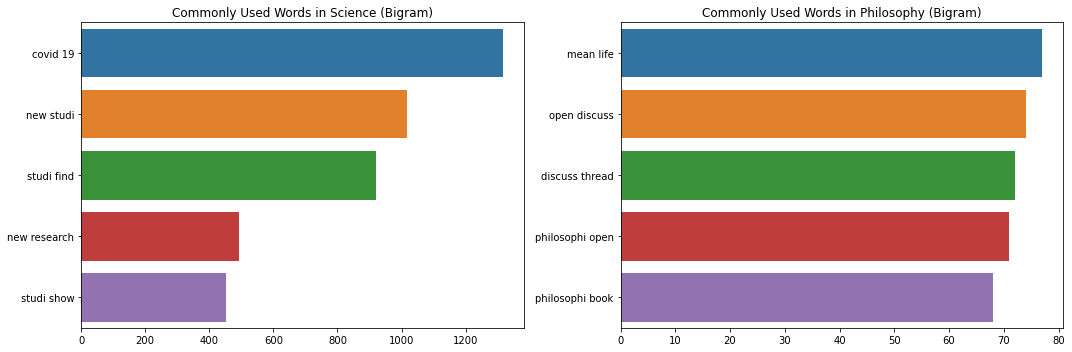

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax1 = sns.barplot(x=sci_bi.values, y=sci_bi.index, ax = ax[0])
ax1.set_title('Commonly Used Words in Science (Bigram)')

ax2 = sns.barplot(x=phi_bi.values, y=phi_bi.index, ax = ax[1])
ax2.set_title('Commonly Used Words in Philosophy (Bigram)')

plt.tight_layout()
plt.show()

- Top words in Science: covid 19, new studi, studi find
- Top words in Philosophy: mean life, open discuss discuss thread

# 03. SENTIMENT ANALYSIS

Analyze the sentiment analysis from each of the subreddits - Science and Philosopy, as well as the major topic from each subreddit - Covid 19 (Science) and Meaning of Life (Philosophy). As a fact-based subreddits, the posts should be delivered in a neutral tone to enhance the credibility of the posts. It should also be noted that the original sentences are not demojised as the majority of our datasets do not contain any emoji. The sentiment of the posts will be trained using Hugging Face [*cardiffnlp/twitter-roberta-base-sentiment-latest*](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest). This model was trained on ~124 million tweets from January 2018 to December 2021, and has included Covid Sentiments in the model.

## a. Science Sentiment Analysis

In [8]:
senti = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
sci['sentiment'] = sci['ori_message'].progress_apply(senti)

100%|██████████| 23698/23698 [17:02<00:00, 23.18it/s]


In [15]:
sci['label'] = [senti[0]['label'] for senti in sci['sentiment']]

In [ ]:
sci.head()

,subreddit,ori_message,message,sentiment,label
0,science,2022 Nobel Prize in Physiology or Medicine to ...,2022 nobel prize physiolog medicin svant pääbo...,"[{'label': 'Positive', 'score': 0.536259472370...",Positive
1,science,India vs South Africa 2nd T20,india vs south africa 2nd t20,"[{'label': 'Neutral', 'score': 0.9182463288307...",Neutral
2,science,Want a better relationship with your dog? Thes...,want better relationship dog 7 factor key,"[{'label': 'Positive', 'score': 0.753991186618...",Positive
3,science,Record avian flu outbreak sees 48m birds culle...,record avian flu outbreak see 48m bird cull uk eu,"[{'label': 'Negative', 'score': 0.810266971588...",Negative
4,science,"In this review article, we focus on the effect...",review articl focu effect oxid fatti acid deri...,"[{'label': 'Neutral', 'score': 0.9199040532112...",Neutral


In [17]:
sci['label'].value_counts(normalize = True)

Neutral     0.680859
Negative    0.188792
Positive    0.130349
Name: label, dtype: float64

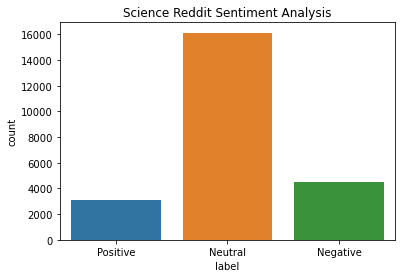

In [39]:
ax1 = sns.countplot(x = sci['label'])
ax1.set_title('Science Reddit Sentiment Analysis')

plt.show();

In [31]:
pd.options.display.max_colwidth = 500
sci[sci['label'] == 'Positive'][['ori_message', 'sentiment']].head()

,ori_message,sentiment
0,2022 Nobel Prize in Physiology or Medicine to Svante Pääbo for his discoveries concerning the genomes of extinct hominins and human evolution,"[{'label': 'Positive', 'score': 0.5362594723701477}]"
2,Want a better relationship with your dog? These 7 factors are key,"[{'label': 'Positive', 'score': 0.7539911866188049}]"
7,"The Nobel Prize in Physiology or Medicine 2022: Awarded to Svante Pääbo ""for his discoveries concerning the genomes of extinct hominins and human evolution""","[{'label': 'Positive', 'score': 0.7330279350280762}]"
11,Svante Pääbo Wins Nobel Prize In Medicine For Discoveries On Human Evolution,"[{'label': 'Positive', 'score': 0.662182629108429}]"
14,Nobel win for Swede who unlocked secrets of Neanderthal DNA,"[{'label': 'Positive', 'score': 0.674126148223877}]"


In [32]:
sci[sci['label'] == 'Negative'][['ori_message', 'sentiment']].head()

,ori_message,sentiment
3,Record avian flu outbreak sees 48m birds culled in UK and EU,"[{'label': 'Negative', 'score': 0.8102669715881348}]"
32,"Researchers ""astonished"" by the number of individuals who consider sex dolls to be their ideal romantic partner","[{'label': 'Negative', 'score': 0.7364408373832703}]"
36,"More than 60% of family caregivers of individuals with Alzheimer's disease (AD) experienced at least mild depressive symptoms already at the time the individual with AD was diagnosed. In one third of them, depressive symptoms worsened during a five-year follow-up","[{'label': 'Negative', 'score': 0.6442731618881226}]"
44,New research demonstrates that political ideology can taint logical reasoning,"[{'label': 'Negative', 'score': 0.6413462162017822}]"
50,/r/bullshit,"[{'label': 'Negative', 'score': 0.8961129188537598}]"


**Observations:** <br>
- 68% of posts are delivered in a neutral tone
- 18% of posts are flagged as 'Positive'. Posts that contain 'wins' are often classified as Positive Sentiment.
- 13% of posts are flagged as 'Negative'.

## b. Philosophy Sentiment Analysis

In [33]:
phi['sentiment'] = phi['ori_message'].progress_apply(senti)

100%|██████████| 18114/18114 [10:26<00:00, 28.90it/s]


In [34]:
phi['label'] = [senti[0]['label'] for senti in phi['sentiment']]

In [35]:
phi.head()

,subreddit,ori_message,message,sentiment,label
0,philosophy,New Razor,new razor,"[{'label': 'Neutral', 'score': 0.7694630026817322}]",Neutral
1,philosophy,"A new tradition is detected in academic philosophy. In addition to ""analytic"" and ""continental"" traditions, a science-oriented tradition emerged (e.g., philosophy of science and experimental philosophy)—and its graduates seem to have better odds of getting a permanent position in academia!",new tradit detect academ philosophi addit analyt continent tradit scienc orient tradit emerg e g philosophi scienc experiment philosophi graduat seem better odd get perman posit academia,"[{'label': 'Positive', 'score': 0.7993433475494385}]",Positive
2,philosophy,Eilish McColgan breaks her own European 10K record in Great North Run,eilish mccolgan break european 10k record great north run,"[{'label': 'Positive', 'score': 0.6338369250297546}]",Positive
3,philosophy,The Agents of Justice,agent justic,"[{'label': 'Neutral', 'score': 0.8418698310852051}]",Neutral
4,philosophy,Philosophy about best friends. It explains whether our best friends are really special or it is just an illusion.,philosophi best friend explain whether best friend realli special just illus,"[{'label': 'Positive', 'score': 0.4850733280181885}]",Positive


In [36]:
phi['label'].value_counts(normalize = True)

Neutral     0.741139
Negative    0.177873
Positive    0.080987
Name: label, dtype: float64

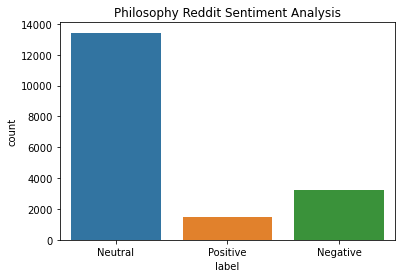

In [38]:
ax1 = sns.countplot(x = phi['label'])
ax1.set_title('Philosophy Reddit Sentiment Analysis')

plt.show();

In [40]:
phi[phi['label'] == 'Positive'][['ori_message', 'sentiment']].head()

,ori_message,sentiment
1,"A new tradition is detected in academic philosophy. In addition to ""analytic"" and ""continental"" traditions, a science-oriented tradition emerged (e.g., philosophy of science and experimental philosophy)—and its graduates seem to have better odds of getting a permanent position in academia!","[{'label': 'Positive', 'score': 0.7993433475494385}]"
2,Eilish McColgan breaks her own European 10K record in Great North Run,"[{'label': 'Positive', 'score': 0.6338369250297546}]"
4,Philosophy about best friends. It explains whether our best friends are really special or it is just an illusion.,"[{'label': 'Positive', 'score': 0.4850733280181885}]"
5,Making God Appeal to the Business World,"[{'label': 'Positive', 'score': 0.7506788969039917}]"
23,Aristotle claims that things that are true and just prevail over their opposites,"[{'label': 'Positive', 'score': 0.5009223818778992}]"


In [41]:
phi[phi['label'] == 'Negative'][['ori_message', 'sentiment']].head()

,ori_message,sentiment
16,"At our core, most of us are not as good as we think we are - we are a mix of ethically good and bad traits. But can close this ‘character gap’ between who we are and who we think we should be.","[{'label': 'Negative', 'score': 0.5968161225318909}]"
17,Idealism and the Decombination Problem,"[{'label': 'Negative', 'score': 0.6122487783432007}]"
20,"Students are being held hostage, arrested and shot at Sharif University. This is not getting the attention it deserves.","[{'label': 'Negative', 'score': 0.9083194136619568}]"
21,@danisuarezac__: a la profe de filosofía no le gusta el drill 😔,"[{'label': 'Negative', 'score': 0.7344262003898621}]"
24,The harsh reality of good people,"[{'label': 'Negative', 'score': 0.7289060354232788}]"


**Observations:** <br>
- 74% of posts are delivered in a neutral tone
- 8% of posts are flagged as 'Positive'
- 17% of posts are flagged as 'Negative'

## c. Science - Covid19 Sentiment

In [46]:
covid19 = sci[sci['message'].str.contains('covid')].copy()

In [47]:
covid19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583 entries, 15 to 23680
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    1583 non-null   object
 1   ori_message  1583 non-null   object
 2   message      1583 non-null   object
 3   sentiment    1583 non-null   object
 4   label        1583 non-null   object
dtypes: object(5)
memory usage: 74.2+ KB


In [48]:
covid19.head()

,subreddit,ori_message,message,sentiment,label
15,science,"Regular Use of Ivermectin as Prophylaxis for COVID-19 Led Up to a 92% Reduction in COVID-19 Mortality Rate in a Dose-Response Manner: Results of a Prospective Observational Study of a Strictly Controlled Population of 88,012 Subjects",regular use ivermectin prophylaxi covid 19 led 92 reduct covid 19 mortal rate dose respons manner result prospect observ studi strictli control popul 88 012 subject,"[{'label': 'Neutral', 'score': 0.8378011584281921}]",Neutral
117,science,Prevalence and risk factors of sleep problems in Bangladesh during the COVID-19 pandemic: a systematic review and meta-analysis,preval risk factor sleep problem bangladesh covid 19 pandem systemat review meta analysi,"[{'label': 'Neutral', 'score': 0.8018679022789001}]",Neutral
127,science,"Effectiveness of mRNA-1273 against infection and COVID-19 hospitalization with SARS-CoV-2 Omicron subvariants: BA.1, BA.2, BA.2.12.1, BA.4, and BA.5",effect mrna 1273 infect covid 19 hospit sar cov 2 omicron subvari ba 1 ba 2 ba 2 12 1 ba 4 ba 5,"[{'label': 'Neutral', 'score': 0.8564528822898865}]",Neutral
128,science,"Fasting as key tone for COVID immunity - In a study published in Nature, Karagiannis et al. show that the ketone body β-hydroxybutyrate (BHB) improves COVID-19 disease outcomes.",fast key tone covid immun studi publish natur karagianni et al show keton bodi β hydroxybutyr bhb improv covid 19 diseas outcom,"[{'label': 'Neutral', 'score': 0.5860148668289185}]",Neutral
156,science,"In a new meta-analysis, COVID-19 vaccination protected only against few long COVID symptoms",new meta analysi covid 19 vaccin protect long covid symptom,"[{'label': 'Neutral', 'score': 0.8187983632087708}]",Neutral


In [49]:
covid19['label'].value_counts(normalize=True)

Neutral     0.629185
Negative    0.310802
Positive    0.060013
Name: label, dtype: float64

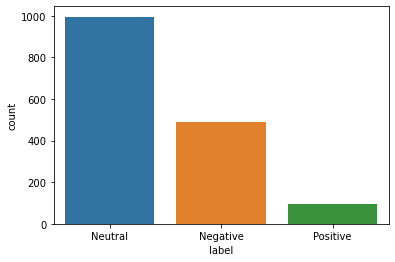

In [50]:
sns.countplot(x = covid19['label'])

plt.show();

In [51]:
# Overview of negative covid19 posts
covid19[covid19['label'] == 'Negative'][['ori_message', 'label']].head(3)

,ori_message,label
282,"Exposure to air pollution worsens COVID-19 outcomes, even among the fully vaccinated. Researchers were able to control for the effects of vaccination status, age, sex, race/ethnicity, health insurance status, body mass index, smoking history, etc.",Negative
290,"Exposure to air pollution worsens COVID-19 outcomes, even among the fully vaccinated. Over the long term, pollution is linked to increases in cardiovascular and lung diseases, which are in turn linked to more severe COVID-19 symptoms.",Negative
315,Trudeau drops COVID Vaccine Mandate because 9 in every 10 Covid-19 Deaths have been among the Triple/Quadruple Vaccinated in the past 3 months,Negative


In [52]:
# Overview of neutral covid19 posts
covid19[covid19['label'] == 'Positive'][['ori_message', 'label']].head(3)

,ori_message,label
631,"New study indicates COVID-19 boosters among vaccinated individuals significantly reduce hospitalization rates, add protection",Positive
1250,UW Medicine research shows Covid-19 boosters well tolerated by pregnant women,Positive
1766,Powerful New Antibody Neutralizes All Known COVID Variants,Positive


**Observations:** <br>
- 63% of posts are delivered in a neutral tone
- 6% of posts are flagged as 'Positive'
- 31% of posts are flagged as 'Negative'

## d. Philosophy - Meaning of Life Sentiment

In [53]:
life = phi[phi['message'].str.contains('life')].copy()

In [54]:
life.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 29 to 18976
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    884 non-null    object
 1   ori_message  884 non-null    object
 2   message      884 non-null    object
 3   sentiment    884 non-null    object
 4   label        884 non-null    object
dtypes: object(5)
memory usage: 41.4+ KB


In [55]:
life.head()

,subreddit,ori_message,message,sentiment,label
29,philosophy,Reddit users have created ethics and mores more stringent than real life,reddit user creat ethic more stringent real life,"[{'label': 'Negative', 'score': 0.641200602054596}]",Negative
50,philosophy,is reproducing literally the only purpose of life?,reproduc liter purpos life,"[{'label': 'Negative', 'score': 0.7297564744949341}]",Negative
51,philosophy,is reproducing literally the only purpose to life?,reproduc liter purpos life,"[{'label': 'Negative', 'score': 0.7447684407234192}]",Negative
70,philosophy,“The Only Constant in Life Is Change.”- Heraclitus Yet this statement itself never changes.,constant life chang heraclitu yet statement never chang,"[{'label': 'Neutral', 'score': 0.7446965575218201}]",Neutral
119,philosophy,"Celebrity, Wealth, and Meaning in Life",celebr wealth mean life,"[{'label': 'Positive', 'score': 0.7339500784873962}]",Positive


In [58]:
life['label'].value_counts(normalize=True)

Neutral     0.617647
Negative    0.207014
Positive    0.175339
Name: label, dtype: float64

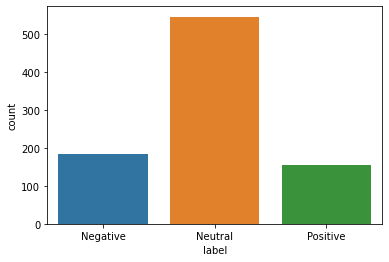

In [59]:
sns.countplot(x = life['label'])

plt.show();

In [56]:
# Overview of negative life posts
life[life['label'] == 'Negative'][['ori_message', 'label']].head(3)

,ori_message,label
29,Reddit users have created ethics and mores more stringent than real life,Negative
50,is reproducing literally the only purpose of life?,Negative
51,is reproducing literally the only purpose to life?,Negative


In [57]:
# Overview of positive life posts
life[life['label'] == 'Positive'][['ori_message', 'label']].head(3)

,ori_message,label
119,"Celebrity, Wealth, and Meaning in Life",Positive
141,"Only fragments of ancient Greek philosopher Epicurus’s writings remain. Among them are his Principal Doctrines: 40 brilliant, authoritative aphorisms that summarize the Epicurean approach to living a good life — an approach focused on removing pain &amp; anxiety, &amp; on emphasizing friendship &amp; community.",Positive
168,"Ubermensch: An Individual who has maximized their virtues, moral and personal, in all dimensions possible. A Beautiful being with limitless potential, invigorating one with excitement, affirming life itself - Niranjan Krishna",Positive


**Observations:** <br>
- 61% of posts are delivered in a neutral tone
- 17% of posts are flagged as 'Positive'
- 20% of posts are flagged as 'Negative'

## e. Summary of Observations

In general, more than 60% of posts are delivered in neutral tone. Observing the remaining 40% of the posts that are labelled as Positive / Negative, some of the datas should be neutral but are categorized otherwise. For example: "New study indicates COVID-19 boosters among vaccinated individuals significantly reduce hospitalization rates, add protection" are labelled as positive. Even though this sentence is a positive sentiment, it is delivered in a neutral tone. Hence, it should be categorized as neutral.

# 04. SUMMARY & RECOMMENDATION

## a. SUMMARY

To achieve the mission as set in the above statement, 25000 posts each are scraped from Science Subreddit & Philosophy Subreddit. Next, data cleaning & EDA are done to examine any missing data, outliers, etc as well as to identify trending topics for each subreddits. The trending topic in Science is Covid19, whereas the trending topic in Philosophy is Meaning of Life. Next, stop words are removed from the texts, and tokenization of texts are executed using Stemming. Baseline model are then developed using Multinomial Naive Bayes with hyperparameter tuning of CountVectorizer and TFIDF Vectorizer. TF-IDF are selected as the Vectorizer and will be used to develop the Final Model. Four types of model with hyperparameter tuning are developed: Multinomial Naive Bayes, Logistic Regression, Random Forest, and SVM. Logistic Regression is selected as the final model to classify whether the posts belong to Science or Philosophy subreddit as it the model with highest accuracy model that is not underfitting / overfitting.

Next, Sentiment analysis of the overall Science & Philosophy are developed using HuggingFace analysis to highlight posts are delivered in non-neutral tone. Additional sentiment analysis will be developed using HuggingFace for the trending topics from each Science (Covid 19) & Philosophy (Meaning of Life). Over 60% of the posts are flagged as neutral in both Science & Philosophy subreddits.

By implementing all the steps mentioned above, if users post in the appropriate subreddits, deliver their posts in a neutral and objective tone, it will greatly reduce the task of Science & Philosophy moderators, as well as improving the overall user experience of reddit readers.

## b. Recommendation

- Classification Models: Although the final model has more than 90% accuracy, it is only developed using 4 types of classification models. Running Pycaret would be ideal to ensure that we have exhausted all classification models
- Sentiment Analysis: We should also manually classify the posts sentiments in order to gauge the accuracy of the models. As shown in earlier segment, there are posts that should be classified as neutral, but are classified as negative. Due to time limitation, only 1 model are developed to analyse the sentiments of the posts. Several huggingface models should be explored and model that yields the best results should be used as the final sentiment analysis model.
- Futher studies: To do a multiclass classification on both Science & Philosophy category based on the topics, as well as expanding to other fact-based subreddits such as: r/Economics, r/Astronomy, etc.